In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Experiments

All models were trained on fold 2 of the AD-DC data

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 0

# baseline: 
# exp_base = {2: "20180328_10_53_16_dcnnv1_150000E_lr2e02",
#            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
# exp_base_model = os.path.join(LOG_DIR, exp_base[TEST_FOLD])

# MC dropout models
# Fold 2: 
# Fold 0: 20180413_16_36_58_dcnn_mcv1_150000E_lr2e02
exp_mc005 = {2: "",
             0: "20180413_16_36_58_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_model = os.path.join(LOG_DIR, exp_mc005[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180416_08_25_43_dcnn_mcv1_150000E_lr2e02
# exp_mc01 = {2: "",
#            0: "20180416_08_25_43_dcnn_mcv1_150000E_lr2e02"}
# exp_mc01_model = os.path.join(LOG_DIR, exp_mc01[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180413_17_03_22_dcnn_mcv1_150000E_lr2e02
exp_mc005_g1000 = {2: "",
                   0: "20180413_17_03_22_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_g1000_model = os.path.join(LOG_DIR, exp_mc005_g1000[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180413_17_03_46_dcnn_mcv1_150000E_lr2e02
exp_mc005_g2000 = {2: "",
                   0: "20180413_17_03_46_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_g2000_model = os.path.join(LOG_DIR, exp_mc005_g2000[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180415_16_04_41_dcnn_mcv1_150000E_lr2e02
exp_mc005_g5000 = {2: "",
                   0: "20180415_16_04_41_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_g5000_model = os.path.join(LOG_DIR, exp_mc005_g5000[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180414_20_20_49_dcnn_mcv1_150000E_lr2e02
exp_mc005_g10000 = {2: "",
                   0: "20180414_20_20_49_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_g10000_model = os.path.join(LOG_DIR, exp_mc005_g10000[TEST_FOLD])




## Load experimental data and test data set

In [3]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_mc005 = ExperimentHandler.load_experiment(exp_mc005_model)
exper_hdl_mc005 = ExperimentHandler(exper_mc005, use_logfile=False)
exper_hdl_mc005.set_root_dir(ROOT_DIR)
exper_hdl_mc005.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc005.exper.run_args.fold_ids[0],
    exper_hdl_mc005.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005.exper.model_name))

exper_mc005_g1000 = ExperimentHandler.load_experiment(exp_mc005_g1000_model)
exper_hdl_mc005_g1000 = ExperimentHandler(exper_mc005_g1000, use_logfile=False)
exper_hdl_mc005_g1000.set_root_dir(ROOT_DIR)
exper_hdl_mc005_g1000.set_model_name("MC-dropout-g{} fold-{} (p={})".format(
                                     exper_hdl_mc005_g1000.exper.run_args.chkpnt_freq,
                                     exper_hdl_mc005_g1000.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_g1000.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_g1000.exper.model_name))

exper_mc005_g2000 = ExperimentHandler.load_experiment(exp_mc005_g2000_model)
exper_hdl_mc005_g2000 = ExperimentHandler(exper_mc005_g2000, use_logfile=False)
exper_hdl_mc005_g2000.set_root_dir(ROOT_DIR)
exper_hdl_mc005_g2000.set_model_name("MC-dropout-g{} fold-{} "
                                     "(p={})".format(exper_hdl_mc005_g2000.exper.run_args.chkpnt_freq,
                                         exper_hdl_mc005_g2000.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_g2000.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_g2000.exper.model_name))

exper_mc005_g5000 = ExperimentHandler.load_experiment(exp_mc005_g5000_model)
exper_hdl_mc005_g5000 = ExperimentHandler(exper_mc005_g5000, use_logfile=False)
exper_hdl_mc005_g5000.set_root_dir(ROOT_DIR)
exper_hdl_mc005_g5000.set_model_name("MC-dropout-g{} fold-{} "
                                     "(p={})".format(exper_hdl_mc005_g5000.exper.run_args.chkpnt_freq,
                                     exper_hdl_mc005_g5000.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_g5000.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_g5000.exper.model_name))

exper_mc005_g10000 = ExperimentHandler.load_experiment(exp_mc005_g10000_model)
exper_hdl_mc005_g10000 = ExperimentHandler(exper_mc005_g10000, use_logfile=False)
exper_hdl_mc005_g10000.set_root_dir(ROOT_DIR)
exper_hdl_mc005_g10000.set_model_name("MC-dropout-g{} fold-{} "
                                     "(p={})".format(exper_hdl_mc005_g10000.exper.run_args.chkpnt_freq,
                                         exper_hdl_mc005_g10000.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_g10000.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_g10000.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc005_g1000.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)

  0%|          | 0/25 [00:00<?, ?it/s]

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 0
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180413_16_36_58_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180413_17_03_22_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-g1000 fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180413_17_03_46_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-g2000 fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180415_16_04_41_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-g5000 fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180414_20_20_49_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-g10000 fold-0 (p=0.05)
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validat

100%|██████████| 25/25 [00:01<00:00, 16.53it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


## Run model evaluation of test set

In [6]:
mc_samples = 1
sample_weights = False
store_details = False
image_range = None
generate_stats = False
save_results = True
checkpoints = None  #  [150000]

exper_handler = exper_hdl_mc005_g2000

exper_handler.logger = None   # exper_hdl_base

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=False, referral_threshold=0., image_range=image_range, checkpoints=checkpoints,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True)


    
print("Ready")

Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180413_17_03_46_dcnn_mcv1_150000E_lr2e02/checkpoints
Evaluating model MC-dropout-g2000 fold-0 (p=0.05) - runID 1
INFO - Running test on 25 images with model from checkpoint 100000
Image 1 - Test accuracy: test loss -1.939	 dice(RV/Myo/LV): ES 0.87/0.83/0.96 --- ED 0.93/0.83/0.96
Image 1 - Test accuracy: test loss -1.939	 Hausdorff(RV/Myo/LV): ES 14.82/12.52/9.90 --- ED 30.03/11.20/10.93
Image 2 - Test accuracy: test loss -3.411	 dice(RV/Myo/LV): ES 0.91/0.85/0.96 --- ED 0.95/0.83/0.96
Image 2 - Test accuracy: test loss -3.411	 Hausdorff(RV/Myo/LV): ES 10.94/16.33/15.65 --- ED 11.46/16.92/13.21
Image 3 - Test accuracy: test loss -2.480	 dice(RV/Myo/LV): ES 0.92/0.83/0.96 --- ED 0.94/0.83/0.97
Image 3 - Test accuracy: test loss -2.480	 Hausdorff(RV/Myo/LV): ES 11.96/11.80/7.92 --- ED 16.33/5.60/5.77
Image 4 - Test accuracy: test loss -0.999	 dice(RV/Myo/LV): ES 0.84/0.90/0.97 --- ED 0.95/0.88/0.98
Im

Image 13 - Test accuracy: test loss -2.436	 dice(RV/Myo/LV): ES 0.86/0.84/0.94 --- ED 0.94/0.83/0.94
Image 13 - Test accuracy: test loss -2.436	 Hausdorff(RV/Myo/LV): ES 12.29/21.37/8.16 --- ED 12.91/10.10/10.10
Image 14 - Test accuracy: test loss -1.489	 dice(RV/Myo/LV): ES 0.88/0.90/0.95 --- ED 0.96/0.87/0.96
Image 14 - Test accuracy: test loss -1.489	 Hausdorff(RV/Myo/LV): ES 10.76/12.91/8.52 --- ED 7.54/15.01/7.54
Image 15 - Test accuracy: test loss -2.693	 dice(RV/Myo/LV): ES 0.78/0.83/0.95 --- ED 0.82/0.83/0.97
Image 15 - Test accuracy: test loss -2.693	 Hausdorff(RV/Myo/LV): ES 12.21/14.07/10.38 --- ED 12.52/7.00/7.92
Image 16 - Test accuracy: test loss -2.362	 dice(RV/Myo/LV): ES 0.85/0.87/0.91 --- ED 0.93/0.84/0.95
Image 16 - Test accuracy: test loss -2.362	 Hausdorff(RV/Myo/LV): ES 15.14/11.20/10.00 --- ED 10.00/10.38/16.33
Image 17 - Test accuracy: test loss -1.006	 dice(RV/Myo/LV): ES 0.78/0.88/0.83 --- ED 0.88/0.88/0.97
Image 17 - Test accuracy: test loss -1.006	 Hausdorff

Image 1 - Test accuracy: test loss -2.013	 dice(RV/Myo/LV): ES 0.86/0.84/0.96 --- ED 0.94/0.82/0.96
Image 1 - Test accuracy: test loss -2.013	 Hausdorff(RV/Myo/LV): ES 12.91/10.00/10.00 --- ED 27.15/18.84/10.93
Image 2 - Test accuracy: test loss -3.417	 dice(RV/Myo/LV): ES 0.90/0.85/0.97 --- ED 0.94/0.83/0.96
Image 2 - Test accuracy: test loss -3.417	 Hausdorff(RV/Myo/LV): ES 11.46/7.00/15.65 --- ED 12.21/16.92/13.21
Image 3 - Test accuracy: test loss -2.564	 dice(RV/Myo/LV): ES 0.92/0.83/0.96 --- ED 0.94/0.83/0.97
Image 3 - Test accuracy: test loss -2.564	 Hausdorff(RV/Myo/LV): ES 13.21/8.52/7.54 --- ED 17.26/5.60/4.43
Image 4 - Test accuracy: test loss -0.999	 dice(RV/Myo/LV): ES 0.86/0.90/0.97 --- ED 0.95/0.88/0.98
Image 4 - Test accuracy: test loss -0.999	 Hausdorff(RV/Myo/LV): ES 13.36/16.02/5.05 --- ED 7.00/18.57/10.00
Image 5 - Test accuracy: test loss -2.389	 dice(RV/Myo/LV): ES 0.83/0.80/0.93 --- ED 0.91/0.80/0.95
Image 5 - Test accuracy: test loss -2.389	 Hausdorff(RV/Myo/LV)

Image 14 - Test accuracy: test loss -1.911	 dice(RV/Myo/LV): ES 0.87/0.89/0.95 --- ED 0.96/0.87/0.97
Image 14 - Test accuracy: test loss -1.911	 Hausdorff(RV/Myo/LV): ES 10.76/10.93/7.14 --- ED 5.94/15.59/7.00
Image 15 - Test accuracy: test loss -2.685	 dice(RV/Myo/LV): ES 0.77/0.82/0.96 --- ED 0.83/0.83/0.97
Image 15 - Test accuracy: test loss -2.685	 Hausdorff(RV/Myo/LV): ES 16.02/13.13/10.00 --- ED 12.21/10.19/7.00
Image 16 - Test accuracy: test loss -2.488	 dice(RV/Myo/LV): ES 0.87/0.87/0.92 --- ED 0.94/0.84/0.95
Image 16 - Test accuracy: test loss -2.488	 Hausdorff(RV/Myo/LV): ES 13.43/10.00/10.00 --- ED 10.00/10.10/12.91
Image 17 - Test accuracy: test loss -1.038	 dice(RV/Myo/LV): ES 0.79/0.88/0.82 --- ED 0.89/0.89/0.97
Image 17 - Test accuracy: test loss -1.038	 Hausdorff(RV/Myo/LV): ES 20.77/13.36/14.82 --- ED 10.94/15.59/10.00
Image 18 - Test accuracy: test loss -3.456	 dice(RV/Myo/LV): ES 0.83/0.91/0.94 --- ED 0.96/0.91/0.97
Image 18 - Test accuracy: test loss -3.456	 Hausdor

[5, 9, 14]
OUTLIERS
[(0, 0), (0, 6), (0, 7), (1, 0), (1, 8), (1, 9), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 8), (2, 7)]


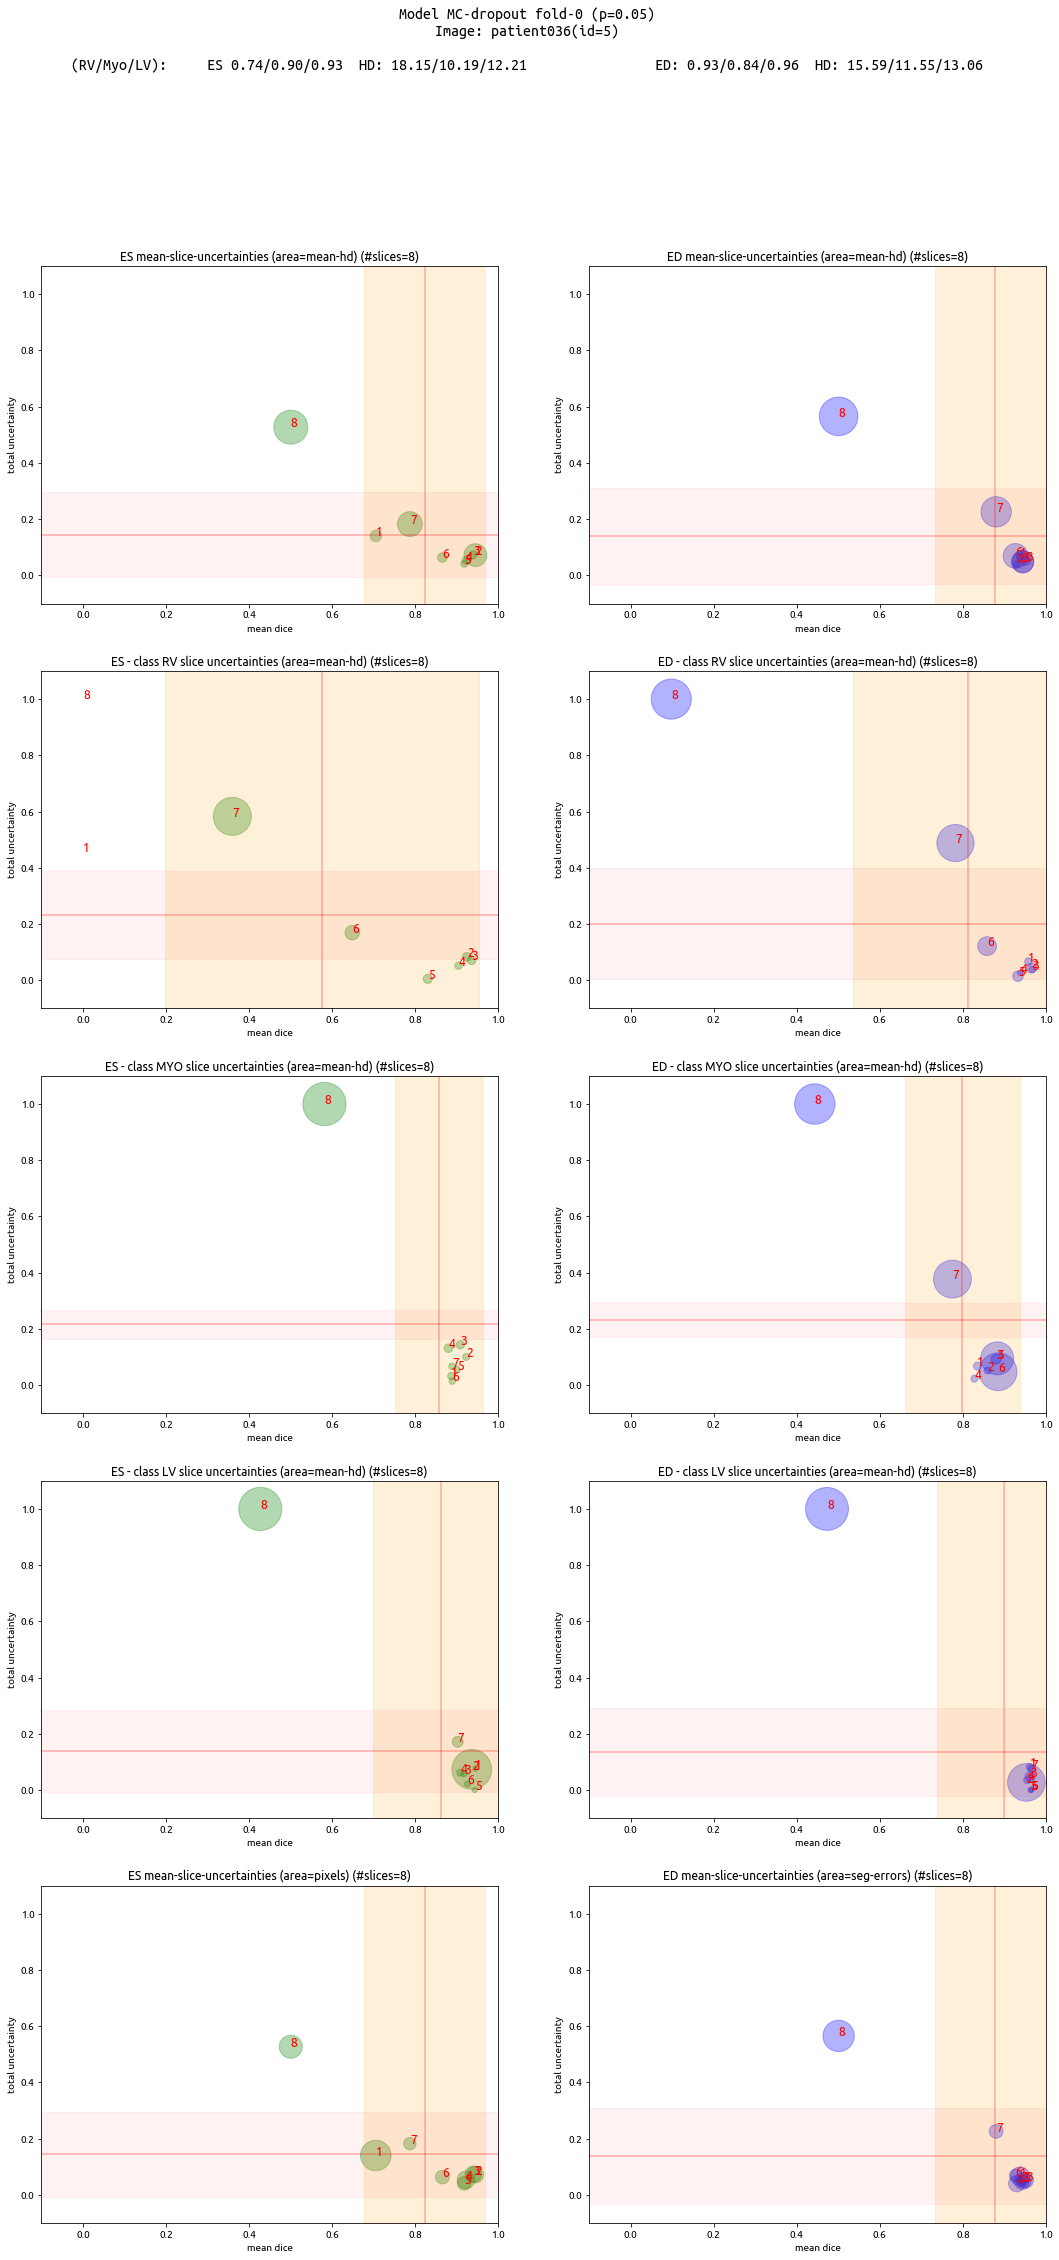

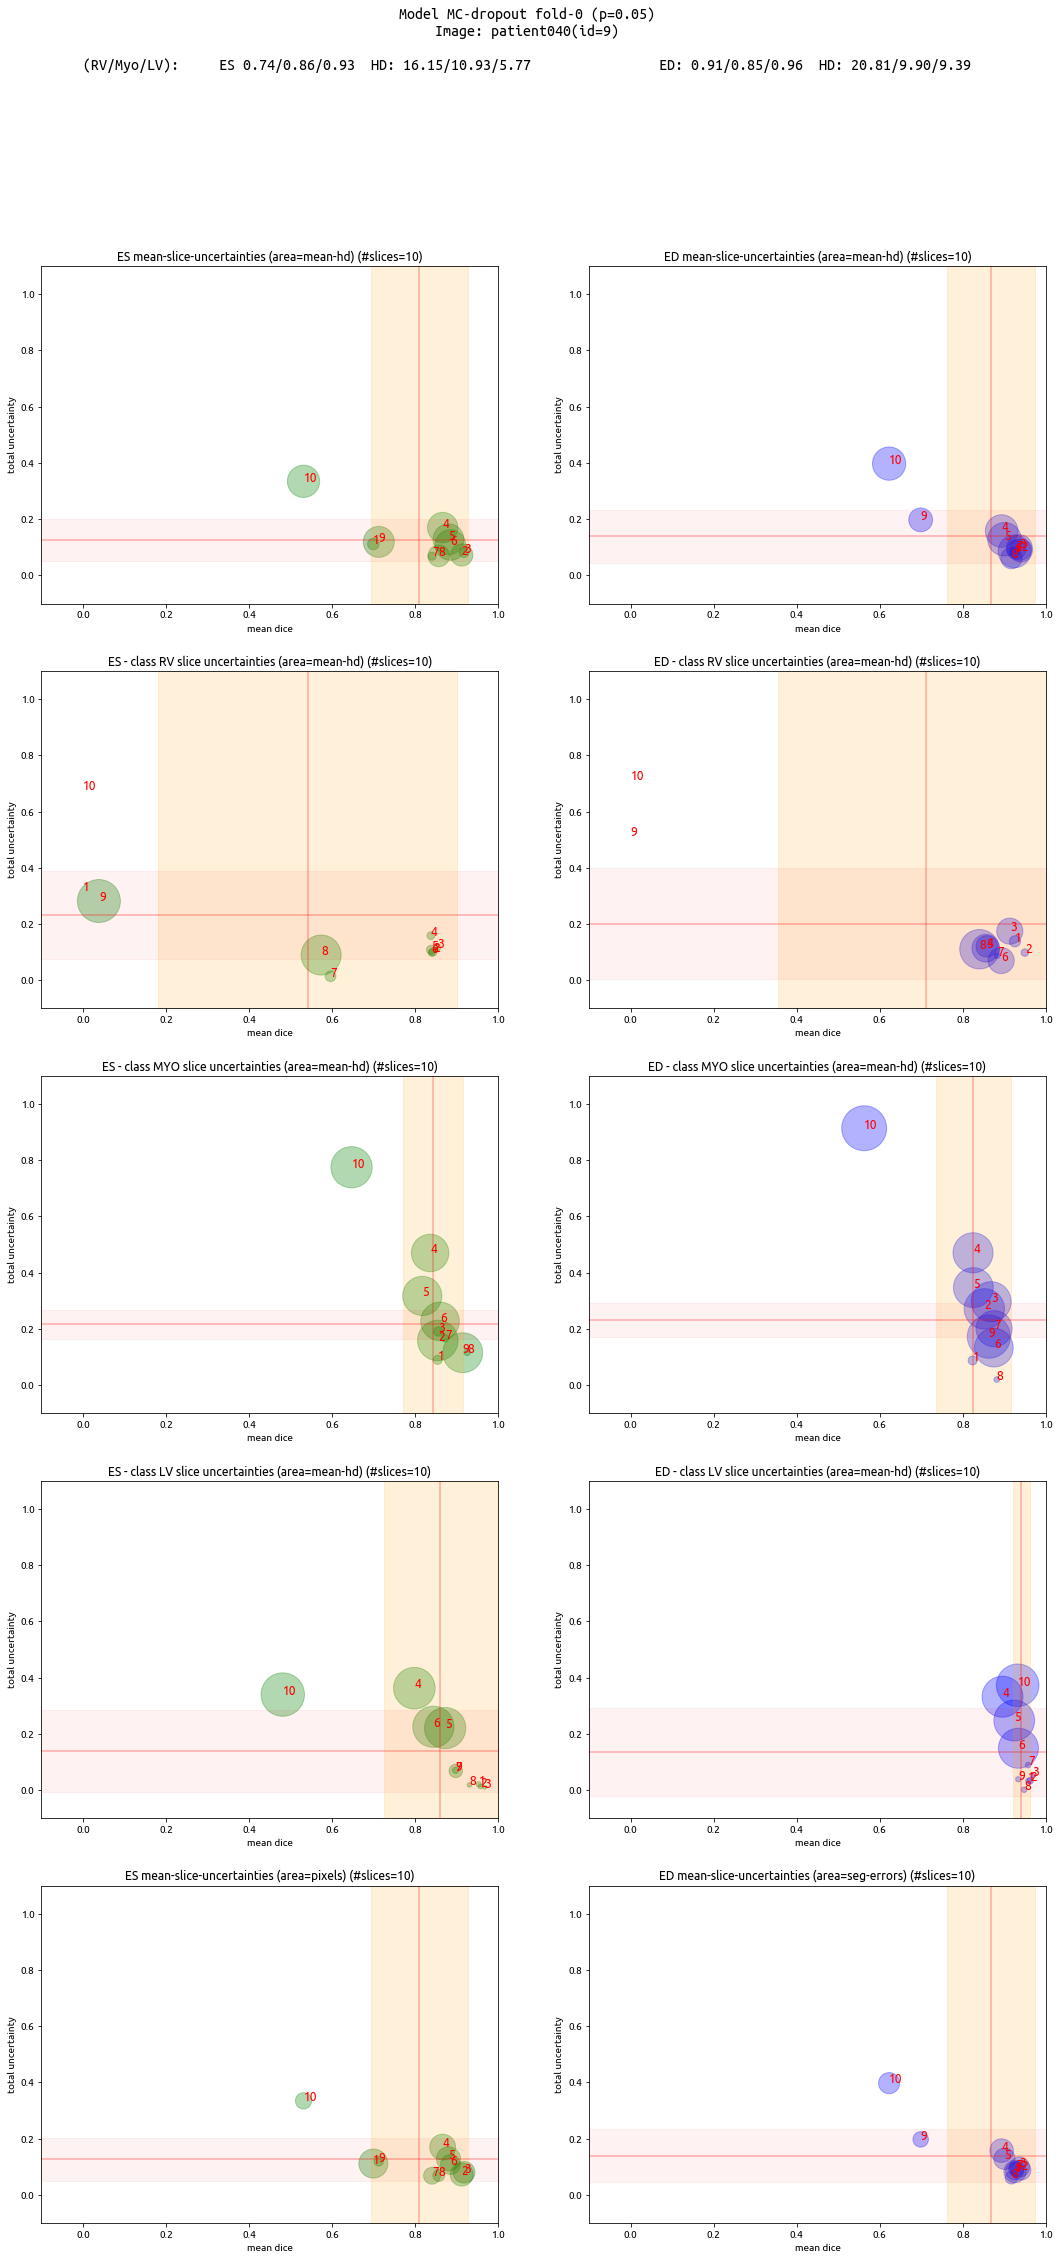

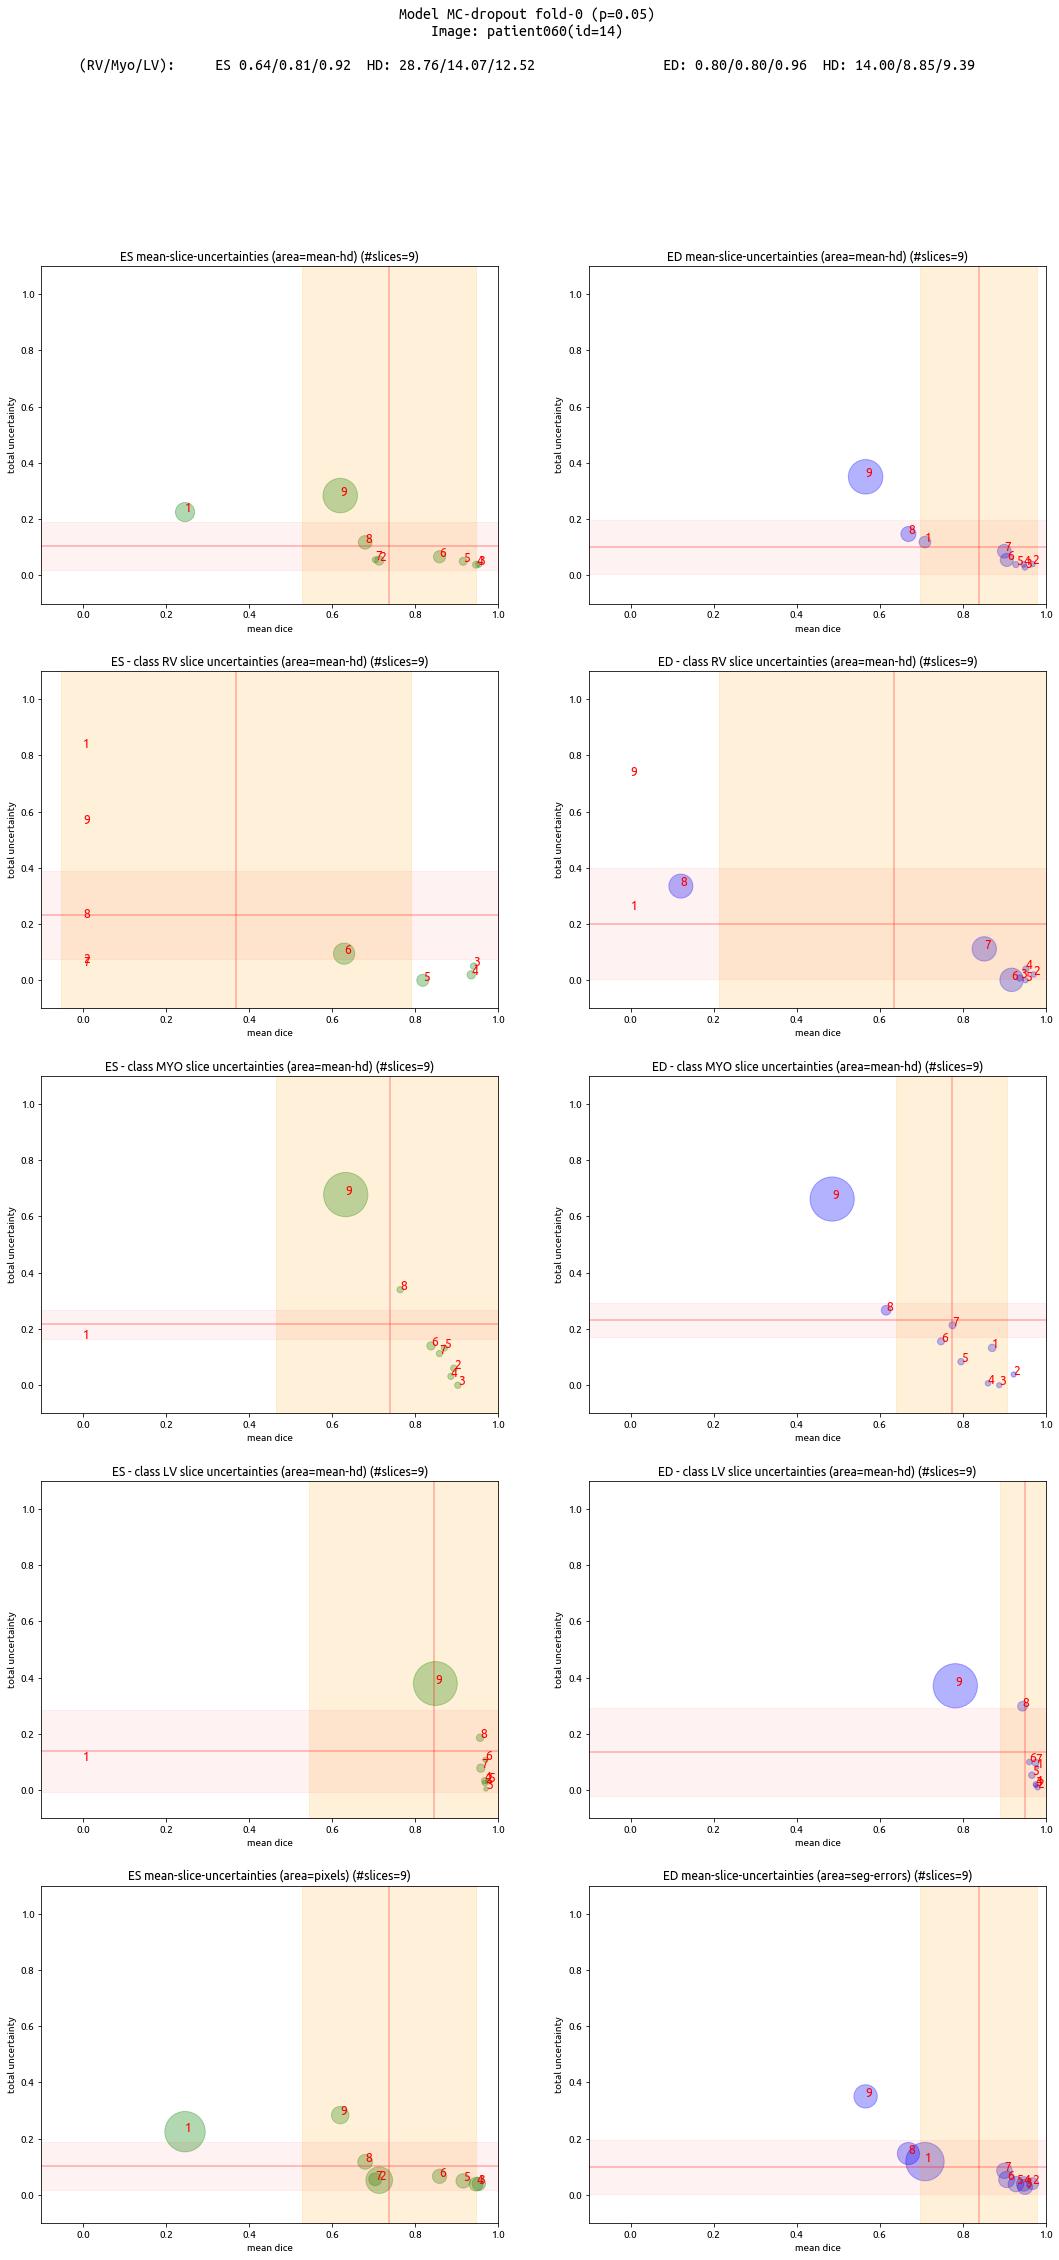

In [106]:
exper_handler = exper_hdl_mc005

image_ids = exper_handler.test_results.image_ids

image_range = None
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=False, do_show=True, u_type=u_type,
               translate_img_range=True)

In [9]:
sample_weights = True
mc_samples = 50
store_details = False
image_range = None  # [5, 9, 14]
generate_stats = False

save_results = False
#  exper_hdl_mc01 exper_hdl_mc025 exp_hdl_mc01_bs  exper_hdl_mc04  exp_hdl_mc01_bs
exper_handler = exper_hdl_mc005
exper_handler.logger = None

print("INFO - Evaluating model {}".format(exper_handler.exper.model_name))

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,
              use_uncertainty=False, referral_threshold=0., image_range=image_range, verbose=False, 
              reset_results=True, use_seed=True,
              store_details=store_details, generate_stats=generate_stats, save_results=save_results,
              do_filter=True, checkpoints=[150000], u_threshold=0.)


    
print("Ready")

INFO - Evaluating model MC-dropout fold-0 (p=0.05)
Evaluating model MC-dropout fold-0 (p=0.05) - runID 1
INFO - Running test on 25 images with model from checkpoint 150000
Image 1 - Test accuracy: test loss -1.546	 dice(RV/Myo/LV): ES 0.83/0.81/0.94 --- ED 0.94/0.83/0.95
Image 1 - Test accuracy: test loss -1.546	 Hausdorff(RV/Myo/LV): ES 10.93/13.28/13.28 --- ED 16.15/14.07/14.28
Image 2 - Test accuracy: test loss -3.154	 dice(RV/Myo/LV): ES 0.87/0.82/0.94 --- ED 0.94/0.82/0.96
Image 2 - Test accuracy: test loss -3.154	 Hausdorff(RV/Myo/LV): ES 19.55/16.39/20.00 --- ED 15.46/17.93/16.33
Image 3 - Test accuracy: test loss -1.935	 dice(RV/Myo/LV): ES 0.91/0.83/0.95 --- ED 0.91/0.82/0.97
Image 3 - Test accuracy: test loss -1.935	 Hausdorff(RV/Myo/LV): ES 27.68/8.16/8.16 --- ED 28.55/15.59/11.20
Image 4 - Test accuracy: test loss -1.053	 dice(RV/Myo/LV): ES 0.90/0.89/0.97 --- ED 0.94/0.88/0.98
Image 4 - Test accuracy: test loss -1.053	 Hausdorff(RV/Myo/LV): ES 10.94/10.76/5.94 --- ED 22.96

In [92]:
sample_weights = True
mc_samples = 10
store_details = True
image_range = [5, 9, 14]
generate_stats = True

save_results = False
#  exper_hdl_mc01 exper_hdl_mc025 exp_hdl_mc01_bs  exper_hdl_mc04  exp_hdl_mc01_bs
exper_handler = exper_hdl_mc005
exper_handler.logger = None

print("INFO - Evaluating model {}".format(exper_handler.exper.model_name))

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,
              use_uncertainty=False, referral_threshold=0., image_range=image_range, verbose=False, 
              reset_results=True, use_seed=True,
              store_details=store_details, generate_stats=generate_stats, save_results=save_results,
              do_filter=True, checkpoints=[150000], u_threshold=0.1)


    
print("Ready")



INFO - Evaluating model MC-dropout fold-0 (p=0.05)
Evaluating model MC-dropout fold-0 (p=0.05) - runID 1
INFO - Running test on 3 images with model from checkpoint 150000
Image 6 - Test accuracy: test loss -1.655	 dice(RV/Myo/LV): ES 0.74/0.90/0.93 --- ED 0.93/0.84/0.96
Image 6 - Test accuracy: test loss -1.655	 Hausdorff(RV/Myo/LV): ES 18.15/10.19/12.21 --- ED 15.59/11.55/13.06
Image 10 - Test accuracy: test loss -1.963	 dice(RV/Myo/LV): ES 0.74/0.86/0.93 --- ED 0.91/0.85/0.96
Image 10 - Test accuracy: test loss -1.963	 Hausdorff(RV/Myo/LV): ES 16.15/10.93/5.77 --- ED 20.81/9.90/9.39
Image 15 - Test accuracy: test loss -2.222	 dice(RV/Myo/LV): ES 0.64/0.81/0.92 --- ED 0.80/0.80/0.96
Image 15 - Test accuracy: test loss -2.222	 Hausdorff(RV/Myo/LV): ES 28.76/14.07/12.52 --- ED 14.00/8.85/9.39
Test accuracy: 	 dice(RV/Myo/LV): ES 0.71 (0.05)/0.85 (0.04)/0.93 (0.00) --- ED 0.88 (0.06)/0.83 (0.02)/0.96 (0.00)
Test accuracy: 	 Hausdorff(RV/Myo/LV): ES 21.02 (5.54)/11.73 (1.68)/10.17 (3.11) 

# Compare performance of models

In [43]:
# info_type="uncertainty"  or probabilities
# model_names a) "Baseline with p=0.5" b) MC-dropout 0.1  c) MC-dropout-Brier 0.1 
handler = exper_hdl_mc01 # exper_hdl_mc01   exper_hdl_base  exp_hdl_mc01_bs  exper_hdl_mc005

for img_idx in image_range:
    handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="uncertainty",
                                                     do_save=True, do_show=False,
                                                     model_name=handler.exper.model_name)

ES correct/error(fp+fn) (561369,) / (4198,)
ED correct/error(fp+fn) (555514,) / (2684,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient012/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (970051,) / (4348,)
ED correct/error(fp+fn) (957985,) / (4622,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient035/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (477827,) / (3186,)
ED correct/error(fp+fn) (472216,) / (4328,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient054/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (637237,) / (4511,)
ED correct/error(fp+fn) (628327,) / (3232,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient074/uncertainty_densities

In [90]:
# model_name a) Baseline  b) MC-dropout 0.1
handler = exper_hdl_mc005  #  exper_hdl_mc01  exper_hdl_base  exp_hdl_mc01_bs
image_range = [9]

for image_num in image_range:
    handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                          info_type="uncertainty",
                                                                 do_save=True, slice_range=None,
                                                                 std_threshold=0., errors_only=False, 
                                                                 do_show=False, use_bald=True,
                                                                 model_name = handler.exper.model_name)
                                                                 # model_name="MC-dropout (0.1)") [0,1,2,3,4,5]
    print("INFO - Ready!")


Rows/columns 14/4
p-values ttest/Mann-Withney-U 0.00E+00/1.29E-303 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/figures/patient040/analysis_seg_err_slice1_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/1.94E-185 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/figures/patient040/analysis_seg_err_slice2_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/1.88E-200 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/figures/patient040/analysis_seg_err_slice3_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/1.05E-245 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/figures/patient040/analysis_seg_err_slice4_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/1.66E-198 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01

In [ ]:
exper_hdl_mc01.test_results.visualize_test_slices(width=20, height=80, slice_range=[0, 5],
                                               do_save=False, image_num=0)

In [ ]:
exper_handler = exper_hdl_mc005_bs
exper_handler.test_results.visualize_prediction_uncertainty(width=20, height=25, slice_range=np.arange(10), 
                                                            do_save=True, std_threshold=None, 
                                                            image_num=0)

Number of subplots 30 columns 5 rows 2 slices 0,1,2
Slice 1 - ES - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ES - Class 2: errors 311 || dice 0.85 || hd  17.03
Slice 1 - ES - Class 3: errors 254 || dice 0.91 || hd  22.40
Slice 1 - ED - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ED - Class 2: errors 385 || dice 0.83 || hd  49.97
Slice 1 - ED - Class 3: errors 175 || dice 0.95 || hd  46.05
Slice 2 - ES - Class 1: errors 5 || dice 0.00 || hd  0.00
Slice 2 - ES - Class 2: errors 311 || dice 0.85 || hd  4.43
Slice 2 - ES - Class 3: errors 134 || dice 0.96 || hd  3.96
Slice 2 - ED - Class 1: errors 207 || dice 0.96 || hd  14.28
Slice 2 - ED - Class 2: errors 236 || dice 0.88 || hd  5.60
Slice 2 - ED - Class 3: errors 78 || dice 0.98 || hd  2.80
Slice 3 - ES - Class 1: errors 163 || dice 0.96 || hd  10.66
Slice 3 - ES - Class 2: errors 229 || dice 0.91 || hd  3.13
Slice 3 - ES - Class 3: errors 83 || dice 0.98 || hd  2.80
Slice 3 - ED - Class 1: errors 185 || dice 0.96 ||

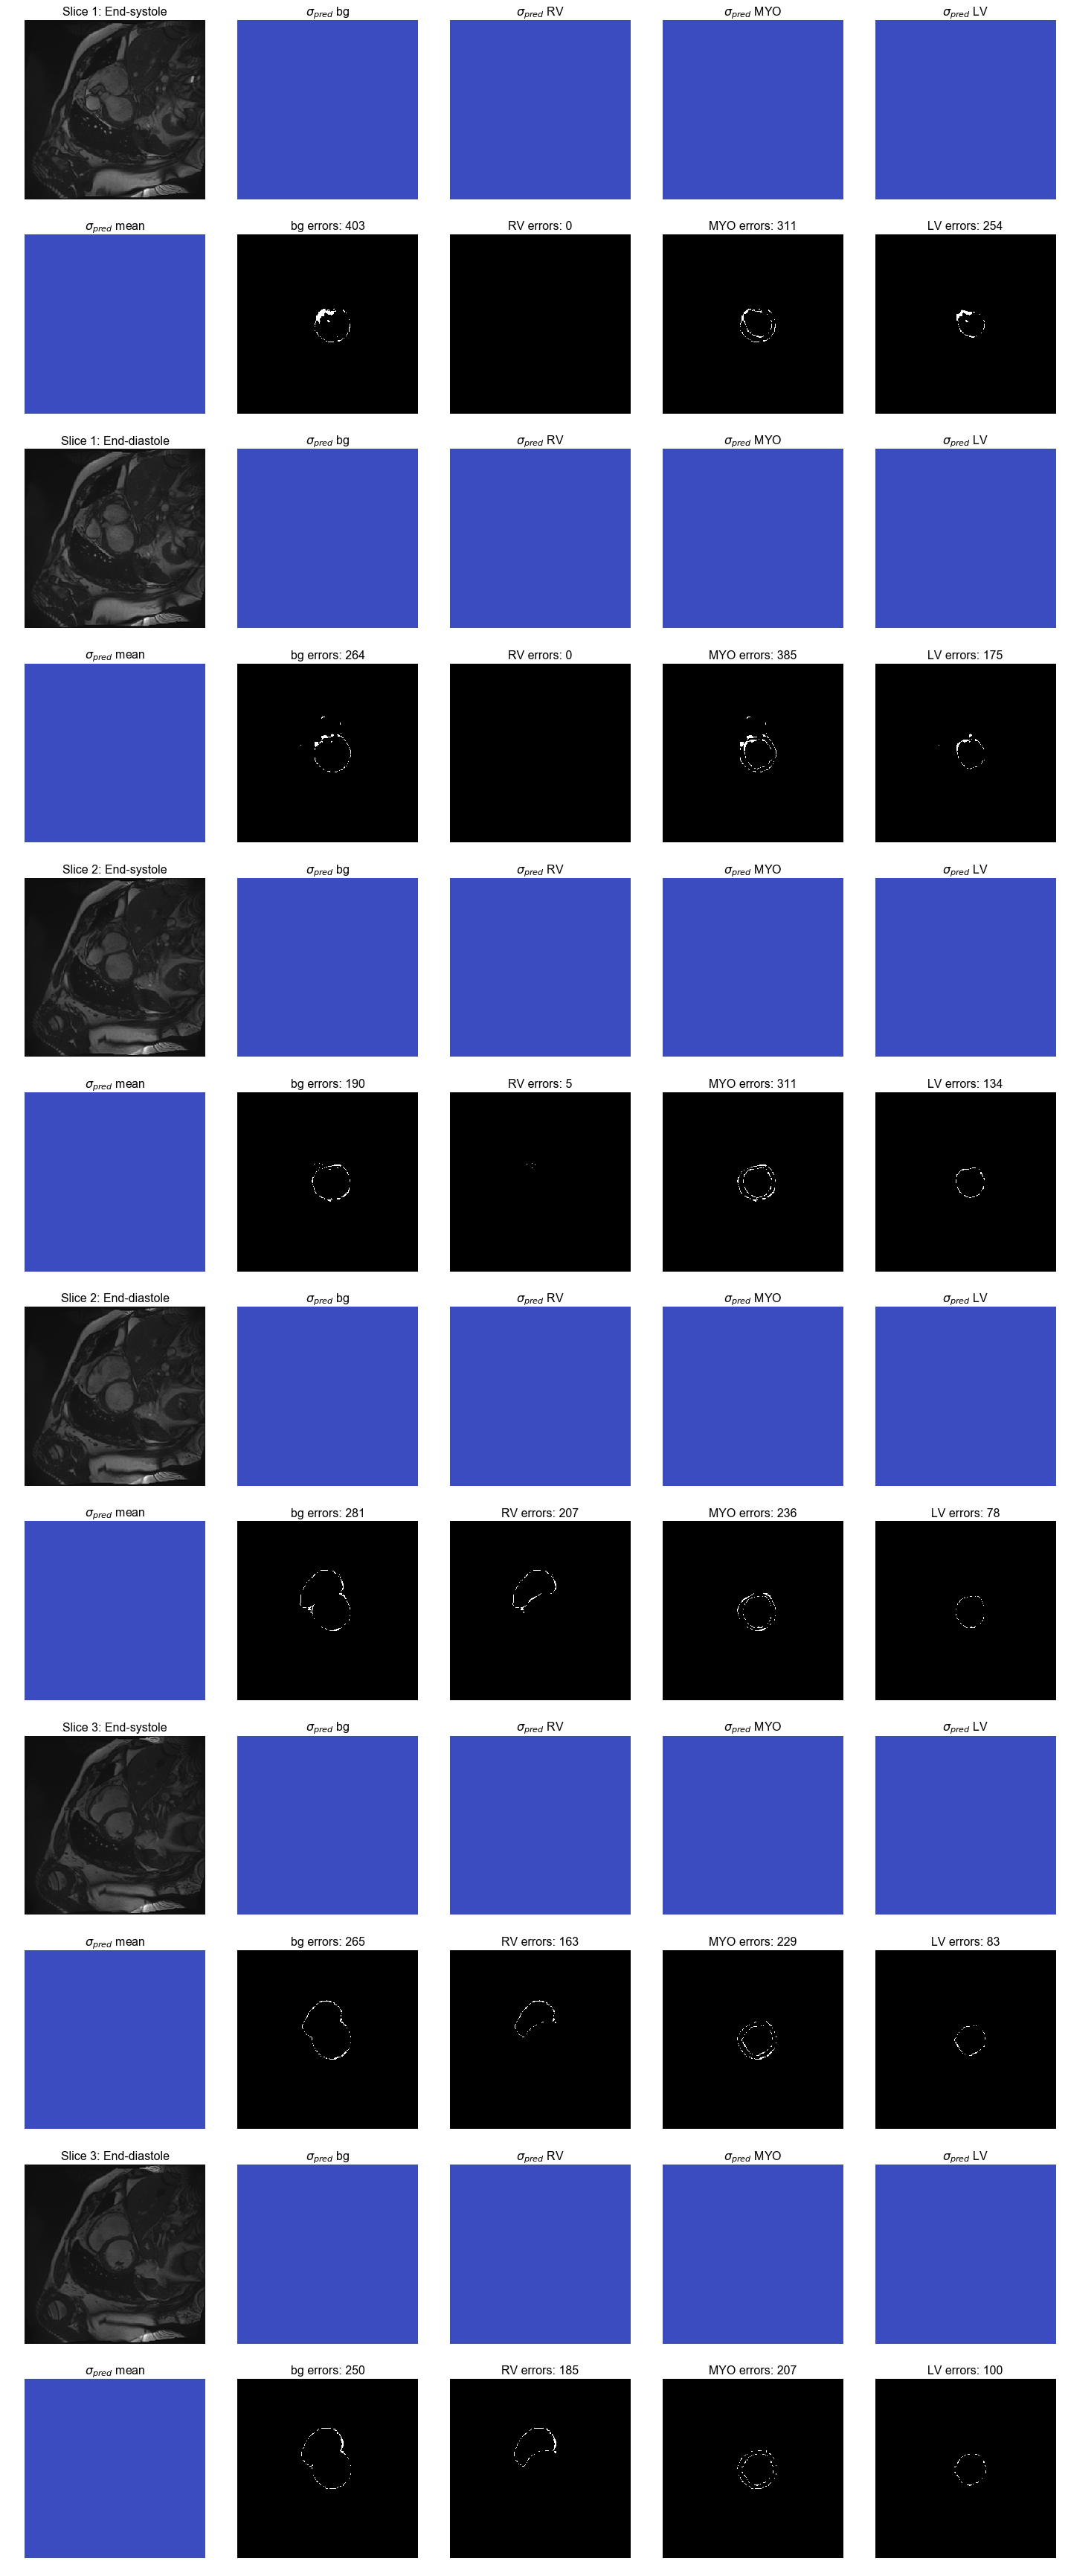

In [85]:
exper_hdl_base.test_results.visualize_prediction_uncertainty(width=20, height=120, slice_range=[0, 1, 2], 
                                                            do_save=False, std_threshold=None)

In [20]:
exp_base_model_exper1 = os.path.join(LOG_DIR, "20180319_10_49_05_dcnnv1_150000E_lr2e02")
exper_base_exper1 = ExperimentHandler.load_experiment(exp_base_model_exper1)
exper_hdl_base_exper1 = ExperimentHandler(exper_base_exper1, use_logfile=False)
exper_hdl_base_exper1.set_root_dir(ROOT_DIR)
exper_hdl_base_exper1.set_model_name("DCNN baseline exper1")

Load from /home/jorg/repository/dcnn_acdc/logs/20180319_10_49_05_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
